# Autoscale Events

I am downloading *Current GWs and SWGs-data* and *Scale Events* from the Grafana AutoScaling Dashboard

The *Scale Events* is the only file used in this script

In [1]:
import warnings
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import re
from datetime import timedelta

In [2]:
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
day_of_the_week = {0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}
pa_regions = {200:"us-west-2", 201:"us-west-201", 210:"ap-south-1", 212:"eu-west-2", 213:"eu-central-1", 214:"us-east-1", 407:"us-south"}

In [4]:
def get_vmid(astring):
    """
    Return the digits in ASTRING
    """
    try:
        vmid = re.findall(r'\d+', astring)
        if len(vmid) > 0:
            return vmid[0].strip()
    except TypeError:
        return None

In [5]:
def get_reason(astring):
    '''
    Return characters in ASTRING after Issue description
    '''
    try:
        reason = re.findall(r'metrics\s+(\w+)', astring)
        if len(reason) > 0:
            return reason[0].strip()
    except TypeError:
        return None

In [6]:
def select_created_deleted(astring):
    """
    Return 2 if the ASTRING is a created event or 1 if it is a deleted
    If it is not either created or deleted, returns 0
    """
    if 'created' in astring:
        return 2
    if 'deleted' in astring:
        return 1
    else:
        return 0

In [7]:
# The only file needed for the script is the Scale Events from Grafana
sca_ev = pd.read_csv(
    "Scale Events (Last 1000)-data-2024-03-04 11_15_51.csv",
    usecols=['create_time', 'scale_type', 'region', 'trigger_reason', 'comments', 'workflow_id'],
    parse_dates=['create_time'])

In [8]:
# classify the type of actions on instances between create, delete or other
sca_ev['action'] = sca_ev['comments'].apply(select_created_deleted)

In [9]:
# select only columns of interest
sca_ev = sca_ev[['create_time', 'region', 'comments', 'action', 'trigger_reason']]

In [10]:
sca_ev = sca_ev.sort_values(by=["create_time"])

In [11]:
sca_ev

,create_time,region,comments,action,trigger_reason
9999,2022-08-15 07:39:41,200,created vmid 4518747026700625267,2,metrics expected_dcpu current region wise meas...
9998,2022-08-15 07:44:31,201,created vmid 5568701994670482165,2,metrics expected_dcpu current region wise meas...
9997,2022-08-15 08:01:43,201,created vmid 2180090776583134971,2,metrics expected_dcpu current region wise meas...
9996,2022-08-15 08:19:00,201,created vmid 1260210907512298174,2,metrics expected_dcpu current region wise meas...
9995,2022-08-15 08:34:00,201,created vmid 4706006844891978073,2,metrics expected_dcpu current region wise meas...
...,...,...,...,...,...
4,2024-03-04 09:33:02,201,created vmid 5814995399593408745,2,metrics expected_dcpu current region wise meas...
3,2024-03-04 09:49:53,201,created vmid 8034558936806569746,2,metrics expected_dcpu current region wise meas...
2,2024-03-04 10:05:43,201,created vmid 3947645878168957715,2,metrics expected_dcpu current region wise meas...
1,2024-03-04 10:17:35,200,created vmid 2412956421521649284,2,metrics expected_dcpu current region wise meas...


In [12]:
# I am not resetting the index on the time series but rather creating additional columns for date and time
sca_ev['date'] = sca_ev["create_time"].apply(lambda x: x.date())
sca_ev['time'] = sca_ev["create_time"].apply(lambda x: x.time())

In [13]:
# remove weird events that are not created or deleted
# extract vmid and trigger reason 
sca_ev = sca_ev.loc[(sca_ev["action"] != 0),:]
sca_ev['vmid'] = sca_ev['comments'].apply(get_vmid)
sca_ev['reason'] = sca_ev['trigger_reason'].apply(get_reason)
sca_ev

,create_time,region,comments,action,trigger_reason,date,time,vmid,reason
9999,2022-08-15 07:39:41,200,created vmid 4518747026700625267,2,metrics expected_dcpu current region wise meas...,2022-08-15,07:39:41,4518747026700625267,expected_dcpu
9998,2022-08-15 07:44:31,201,created vmid 5568701994670482165,2,metrics expected_dcpu current region wise meas...,2022-08-15,07:44:31,5568701994670482165,expected_dcpu
9997,2022-08-15 08:01:43,201,created vmid 2180090776583134971,2,metrics expected_dcpu current region wise meas...,2022-08-15,08:01:43,2180090776583134971,expected_dcpu
9996,2022-08-15 08:19:00,201,created vmid 1260210907512298174,2,metrics expected_dcpu current region wise meas...,2022-08-15,08:19:00,1260210907512298174,expected_dcpu
9995,2022-08-15 08:34:00,201,created vmid 4706006844891978073,2,metrics expected_dcpu current region wise meas...,2022-08-15,08:34:00,4706006844891978073,expected_dcpu
...,...,...,...,...,...,...,...,...,...
4,2024-03-04 09:33:02,201,created vmid 5814995399593408745,2,metrics expected_dcpu current region wise meas...,2024-03-04,09:33:02,5814995399593408745,expected_dcpu
3,2024-03-04 09:49:53,201,created vmid 8034558936806569746,2,metrics expected_dcpu current region wise meas...,2024-03-04,09:49:53,8034558936806569746,expected_dcpu
2,2024-03-04 10:05:43,201,created vmid 3947645878168957715,2,metrics expected_dcpu current region wise meas...,2024-03-04,10:05:43,3947645878168957715,expected_dcpu
1,2024-03-04 10:17:35,200,created vmid 2412956421521649284,2,metrics expected_dcpu current region wise meas...,2024-03-04,10:17:35,2412956421521649284,expected_dcpu


In [14]:
# vmid are created every time a GW is spun off and sorting by that number helps id events
sca_ev = sca_ev.sort_values(by=['vmid']).reset_index(drop=True)

In [15]:
# create a new data frame with the duration, vmid, reason and date for each completed autoscale
i = 0
autoscale = pd.DataFrame(columns=["duration", "vmid", "region", "date", "reason"])

while i < sca_ev.shape[0] - 1:
    vmid = sca_ev.iloc[i, 7]
    if sca_ev.iloc[i + 1, 7] == vmid:
        if sca_ev.iloc[i,3] == 2:
            autoscale.loc[i] = (sca_ev.iloc[i+1,0] - sca_ev.iloc[i,0], sca_ev.iloc[i,7], 
                                sca_ev.iloc[i,1], sca_ev.iloc[i,5], sca_ev.iloc[i,8])
        else:
            autoscale.loc[i] = (sca_ev.iloc[i,0] - sca_ev.iloc[i+1,0], sca_ev.iloc[i,7], 
                                sca_ev.iloc[i,1], sca_ev.iloc[i,5], sca_ev.iloc[i,8])
        i += 2    
    else:
        i += 1

In [16]:
# sorting the new dataframe by date
autoscale = autoscale.sort_values(by=["date"], ascending=False).reset_index(drop=True)
autoscale["year"] = autoscale["date"].apply(lambda x: x.year)
autoscale["month"] = autoscale["date"].apply(lambda x: x.month)
autoscale["day"] = autoscale["date"].apply(lambda x: x.day)
autoscale["weekday"] = autoscale["date"].apply(lambda x: x.weekday())
autoscale["autohours"] = autoscale["duration"].apply(lambda x: x.total_seconds() // 3600)

In [17]:
# filtering by events from 2024
autoscale2024 = autoscale.loc[(autoscale["year"] >= 2024),:]
autoscale2024.replace({'region': pa_regions}, inplace=True)
autoscale2024.replace({'weekday': day_of_the_week}, inplace=True)
autoscale2024

,duration,vmid,region,date,reason,year,month,day,weekday,autohours
0,0 days 17:09:54,8757811900236762279,us-west-201,2024-03-01,expected_dcpu,2024,3,1,Friday,17.0
1,0 days 18:10:05,3045639425306151549,us-west-201,2024-03-01,expected_dcpu,2024,3,1,Friday,18.0
2,0 days 10:02:53,6196563884762965889,us-west-201,2024-03-01,expected_dcpu,2024,3,1,Friday,10.0
3,0 days 14:14:50,513923531945261127,us-west-201,2024-03-01,expected_dcpu,2024,3,1,Friday,14.0
4,0 days 07:54:22,4577344171740731091,us-west-201,2024-03-01,expected_dcpu,2024,3,1,Friday,7.0
...,...,...,...,...,...,...,...,...,...,...
402,0 days 09:55:58,4489861481830675078,us-west-201,2024-01-02,expected_dcpu,2024,1,2,Tuesday,9.0
403,0 days 14:45:38,8467688985399494276,us-west-201,2024-01-02,expected_dcpu,2024,1,2,Tuesday,14.0
404,0 days 11:45:55,8958505813488040835,us-west-201,2024-01-02,expected_dcpu,2024,1,2,Tuesday,11.0
405,0 days 12:52:34,7457809463915446260,us-west-201,2024-01-02,expected_dcpu,2024,1,2,Tuesday,12.0


In [18]:
# summarizing the events
autoscale2024.groupby(by=["region"]).agg(
    count = pd.NamedAgg("region", aggfunc="count"))

,count
region,
us-west-2,11
us-west-201,396


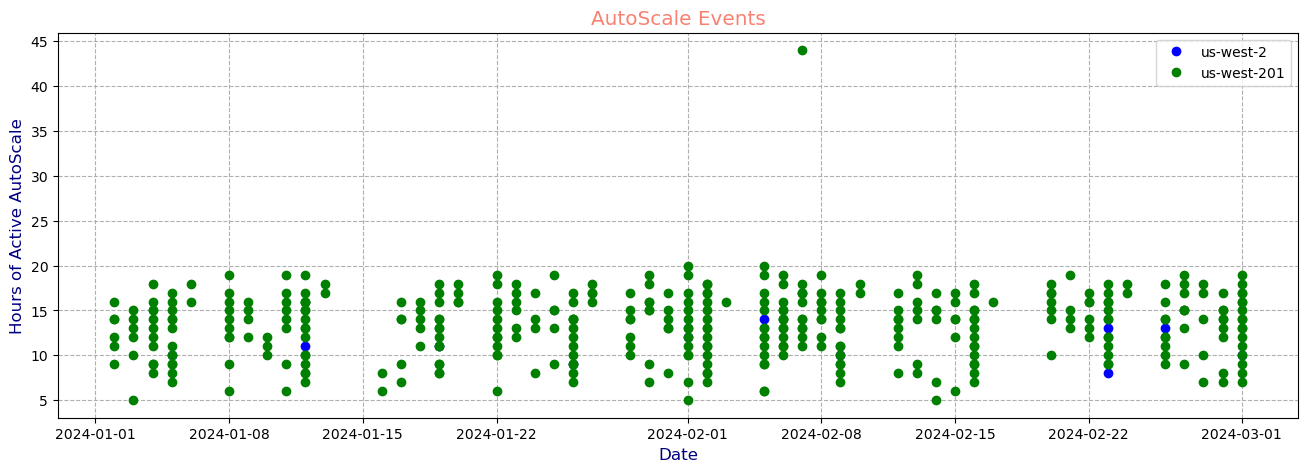

In [19]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(autoscale2024.loc[(autoscale2024["region"] == "us-west-2"), :]["date"], 
        autoscale2024.loc[(autoscale2024["region"] == "us-west-2"), :]["autohours"], 'bo', label="us-west-2")
ax.plot(autoscale2024.loc[(autoscale2024["region"] == "us-west-201"), :]["date"], 
        autoscale2024.loc[(autoscale2024["region"] == "us-west-201"), :]["autohours"], 'go', label="us-west-201")

ax.legend()
ax.grid(ls='--')

fontdict_title = {'fontsize': 'x-large',
 'fontweight': 'regular',
 'color': 'salmon',
 'verticalalignment': 'baseline',
 'horizontalalignment': 'center'}

fontdict_x = {'fontsize': 'large',
 'fontweight': 'regular',
 'color': 'navy',
 'verticalalignment': 'top',
 'horizontalalignment': 'center'}

fontdict_y = {'fontsize': 'large',
 'fontweight': 'regular',
 'color': 'navy',
 'verticalalignment': 'bottom',
 'horizontalalignment': 'center'}


ax.set_title("AutoScale Events", fontdict=fontdict_title)
ax.set_xlabel("Date", fontdict=fontdict_x)
ax.set_ylabel("Hours of Active AutoScale", fontdict=fontdict_y)


fig.savefig("autoscaleRegion.png")



In [20]:
# summarizing the events
autoscale2024.groupby(by=["reason"]).agg(
    count = pd.NamedAgg("reason", aggfunc="count"))

,count
reason,
expected_dcpu,385
user_count,22


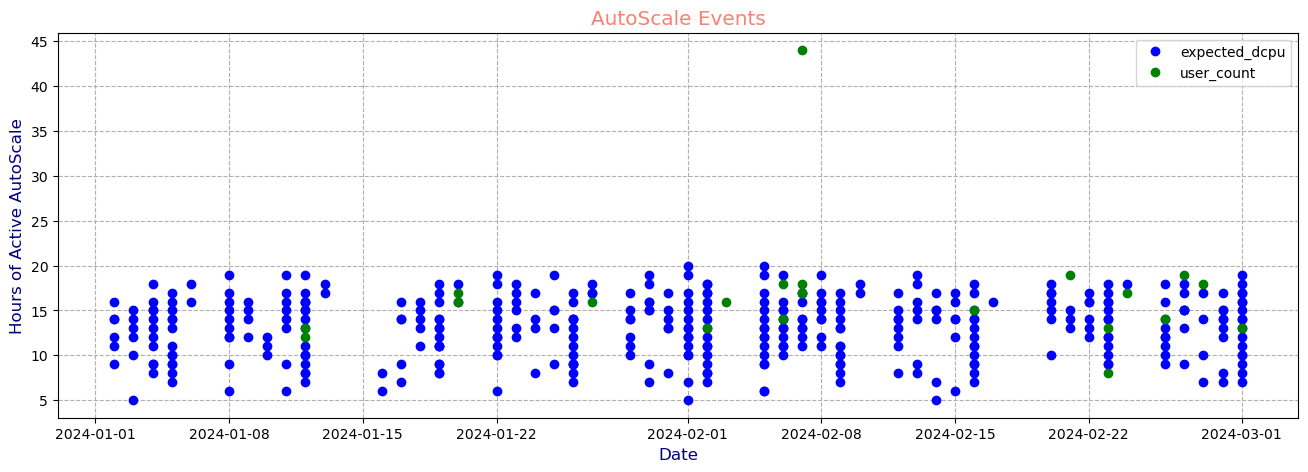

In [21]:
fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(autoscale2024.loc[(autoscale2024["reason"] == "expected_dcpu"), :]["date"], 
        autoscale2024.loc[(autoscale2024["reason"] == "expected_dcpu"), :]["autohours"], 'bo', label="expected_dcpu")
ax.plot(autoscale2024.loc[(autoscale2024["reason"] == "user_count"), :]["date"], 
        autoscale2024.loc[(autoscale2024["reason"] == "user_count"), :]["autohours"], 'go', label="user_count")

ax.legend()
ax.grid(ls='--')

fontdict_title = {'fontsize': 'x-large',
 'fontweight': 'regular',
 'color': 'salmon',
 'verticalalignment': 'baseline',
 'horizontalalignment': 'center'}

fontdict_x = {'fontsize': 'large',
 'fontweight': 'regular',
 'color': 'navy',
 'verticalalignment': 'top',
 'horizontalalignment': 'center'}

fontdict_y = {'fontsize': 'large',
 'fontweight': 'regular',
 'color': 'navy',
 'verticalalignment': 'bottom',
 'horizontalalignment': 'center'}


ax.set_title("AutoScale Events", fontdict=fontdict_title)
ax.set_xlabel("Date", fontdict=fontdict_x)
ax.set_ylabel("Hours of Active AutoScale", fontdict=fontdict_y)


fig.savefig("autoscaleReason.png")



In [22]:
summary_reason = autoscale2024.groupby(by=["region", "reason"]).agg(
    count = pd.NamedAgg("reason", aggfunc="count"))

In [23]:
summary_reason

count
region      reason              
us-west-2   expected_dcpu      9
            user_count         2
us-west-201 expected_dcpu    376
            user_count        20

In [24]:
summary_reason.to_excel("summary_reason.xlsx")

In [25]:
autoscale2024["autohours"].mean()

13.321867321867321

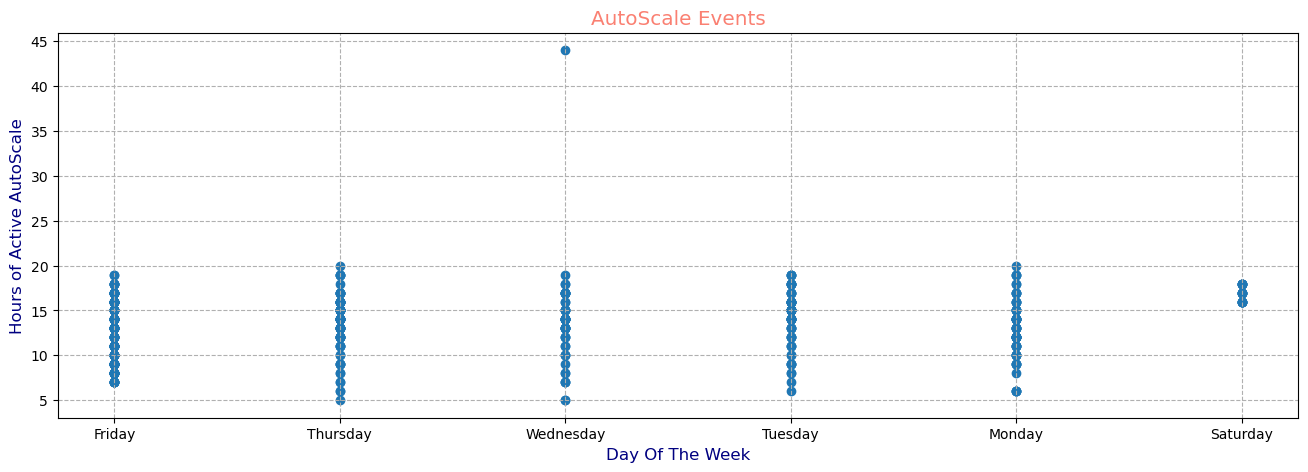

In [26]:
fig, ax = plt.subplots(figsize=(16, 5))
x = autoscale2024['weekday']
y = autoscale2024['autohours']
ax.scatter(x, y)

ax.grid(ls='--')

fontdict_title = {'fontsize': 'x-large',
 'fontweight': 'regular',
 'color': 'salmon',
 'verticalalignment': 'baseline',
 'horizontalalignment': 'center'}

fontdict_x = {'fontsize': 'large',
 'fontweight': 'regular',
 'color': 'navy',
 'verticalalignment': 'top',
 'horizontalalignment': 'center'}

fontdict_y = {'fontsize': 'large',
 'fontweight': 'regular',
 'color': 'navy',
 'verticalalignment': 'bottom',
 'horizontalalignment': 'center'}


ax.set_title("AutoScale Events", fontdict=fontdict_title)
ax.set_xlabel("Day Of The Week", fontdict=fontdict_x)
ax.set_ylabel("Hours of Active AutoScale", fontdict=fontdict_y)


fig.savefig("autoscaleWeek.png")



In [27]:
summary_days = autoscale2024.groupby(by=["weekday"]).agg(
    count = pd.NamedAgg("weekday", aggfunc="count"))
summary_days

,count
weekday,
Friday,139
Monday,63
Saturday,18
Thursday,74
Tuesday,62
Wednesday,51


In [28]:
summary_days.to_excel("summary_days.xlsx")